In [312]:
import numpy as np
np.set_printoptions(precision=4)
from scipy.stats import norm, multivariate_normal as mvn
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [313]:

class OnlineEmpiricalCDF:
    def __init__(self, n_cdfs, n_bins=40000, value_range=(-1.0, 1.0)):
        """
        n_cdfs: number of CDFs to track (e.g., number of projection directions)
        n_bins: number of histogram bins
        value_range: (min_val, max_val) range of expected values
        """
        self.K = n_cdfs
        self.n_bins = n_bins
        self.vmin, self.vmax = value_range

        self.bin_edges = np.linspace(self.vmin, self.vmax, n_bins + 1)
        self.bin_counts = np.zeros((self.K, n_bins), dtype=np.int32)
        self.total_counts = np.zeros(self.K, dtype=np.int32)

    def _bin_indices(self, values):
        # Map values to histogram bin indices
        scaled = (values - self.vmin) / (self.vmax - self.vmin)
        indices = np.floor(scaled * self.n_bins).astype(np.int32)
        return np.clip(indices, 0, self.n_bins - 1)

    def update(self, values):
        """
        values: array of shape (K,) — new projected values (one per CDF)
        """
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"
        indices = self._bin_indices(values)
        for k in range(self.K):
            self.bin_counts[k, indices[k]] += 1
            self.total_counts[k] += 1

    def query(self, values):
        """
        values: array of shape (K,) — query CDF values (one per CDF)
        Returns: array of shape (K,) — CDF estimates
        """
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"
        indices = self._bin_indices(values)
        cdf_vals = np.zeros(self.K)
        for k in range(self.K):
            count = self.bin_counts[k, :indices[k]].sum()
            total = self.total_counts[k]
            cdf_vals[k] = count / total if total > 0 else 0.0
        return cdf_vals
    
    def query_update(self, values):
        """
        values: array of shape (K,) — input values to query and then update
        Returns: array of shape (K,) — CDF estimates *before* update
        """
        assert values.shape == (self.K,), "Input must have shape (n_cdfs,)"

        indices = self._bin_indices(values)

        # Compute CDF values before updating
        mask = np.arange(self.n_bins)[None, :] < indices[:, None]  # shape (K, n_bins)
        counts_before = np.sum(self.bin_counts * mask, axis=1)
        totals_before = self.total_counts
        cdf_vals = np.where(totals_before > 0, counts_before / totals_before, 0.0)

        # Update in same pass
        self.total_counts += 1
        self.bin_counts[np.arange(self.K), indices] += 1

        return cdf_vals


In [314]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)

In [315]:
# Mixture components
means = np.stack([mean1, mean2, mean3, mean4])
covs = np.stack([cov1, cov2, cov3, cov4])
weights = np.array([w1, w2, w3, w4])

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    """
    dirs: (K, 2) projection directions
    xt: (2,) current point
    means: (M, 2)
    covs: (M, 2, 2)
    weights: (M,)
    Returns: pdfs (K,), cdfs (K,), proj_xt (K,)
    """
    K = dirs.shape[0]
    M = means.shape[0]
    # Project xt to each direction
    proj_xt = dirs @ xt            # (K,)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances: θᵢᵀ Σ θᵢ for each (K, M)
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]  # (2, 2)
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)  # (K,)

    proj_stds = np.sqrt(proj_vars + 1e-12)  # (M, K), numerical stability

    # Compute PDF and CDF for each component at proj_xt: (M, K)
    proj_xt_expand = proj_xt[None, :]  # (1, K)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)

    # Weighted sum over components
    weighted_pdfs = (weights[:, None] * pdfs).sum(axis=0)  # (K,)
    weighted_cdfs = (weights[:, None] * cdfs).sum(axis=0)  # (K,)

    return weighted_pdfs, weighted_cdfs, proj_xt

In [316]:
""" This seems to be the best metric for now"""
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
pdf_vals = pdf(grids)

import ot
def sample_from_density_2d(p_vals, x_grid, y_grid, n_samples = 10000):
    """Sample from 2D density given over meshgrid"""
    H, W = p_vals.shape
    flat_p = p_vals.ravel()
    flat_p /= flat_p.sum()  # Normalize

    indices = np.random.choice(H * W, size=n_samples, p=flat_p)
    x_flat = x_grid.ravel()[indices]
    y_flat = y_grid.ravel()[indices]
    return np.stack([x_flat, y_flat], axis=1)

def compute_wasserstein_2d(p_vals, x_grid, y_grid, f_vals, n_samples=10000):
    """
    p_vals: shape (H, W) — density over 2D domain
    x_grid, y_grid: shape (H, W) — meshgrid defining coordinates
    f_vals: shape (N, 2) — pushforward samples along f:[0,1]->X
    """

    # Sample from μ
    mu_samples = sample_from_density_2d(p_vals, x_grid, y_grid, n_samples)

    # Downsample or interpolate f_vals to n_samples
    if len(f_vals) > n_samples:
        indices = np.linspace(0, len(f_vals)-1, n_samples).astype(int)
        nu_samples = f_vals[indices]
    else:
        nu_samples = f_vals

    # Empirical uniform weights
    a = np.ones(len(mu_samples)) / len(mu_samples)
    b = np.ones(len(nu_samples)) / len(nu_samples)

    # Compute cost matrix (squared Euclidean distances)
    M = ot.dist(mu_samples, nu_samples, metric='euclidean')
    
    # Compute Wasserstein-1
    W1 = ot.emd2(a, b, M)  # returns W1^2 if squared, but here with p=1, it's W1

    return W1

In [317]:
# Parameters
dt_emp = 0.01 ### Choose as the time we want i.e f:[0,t] -> X with t = dt_emp*T
T = 100000
dt = 1/T            # Time steps
v_max = 0.2 * dt_emp * T # Max speed
d = 2                # Dimension
n_dirs = 100          # Number of projection directions
# Projection directions (unit vectors on S^1)
angles = np.random.uniform(0, 2 * np.pi, size=n_dirs)
dirs = np.stack((np.cos(angles), np.sin(angles)), axis=1)  # shape: (n_dirs, 2)

# Mixture components
means = np.stack([mean1, mean2, mean3, mean4])
covs = np.stack([cov1, cov2, cov3, cov4])
weights = np.array([w1, w2, w3, w4])

def projected_pdf_cdf_mog(dirs, xt, means, covs, weights):
    """
    dirs: (K, 2) projection directions
    xt: (2,) current point
    means: (M, 2)
    covs: (M, 2, 2)
    weights: (M,)
    Returns: pdfs (K,), cdfs (K,), proj_xt (K,)
    """
    K = dirs.shape[0]
    M = means.shape[0]
    # Project xt to each direction
    proj_xt = dirs @ xt            # (K,)
    
    # Project means: (M, K)
    proj_means = means @ dirs.T    # (M, K)
    
    # Project variances: θᵢᵀ Σ θᵢ for each (K, M)
    proj_vars = np.zeros((M, K))
    for m in range(M):
        Sigma_m = covs[m]  # (2, 2)
        proj_vars[m] = np.sum(dirs @ Sigma_m * dirs, axis=1)  # (K,)

    proj_stds = np.sqrt(proj_vars + 1e-12)  # (M, K), numerical stability

    # Compute PDF and CDF for each component at proj_xt: (M, K)
    proj_xt_expand = proj_xt[None, :]  # (1, K)
    pdfs = norm.pdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)
    cdfs = norm.cdf(proj_xt_expand, loc=proj_means, scale=proj_stds)  # (M, K)

    # Weighted sum over components
    weighted_pdfs = (weights[:, None] * pdfs).sum(axis=0)  # (K,)
    weighted_cdfs = (weights[:, None] * cdfs).sum(axis=0)  # (K,)

    return weighted_pdfs, weighted_cdfs, proj_xt
# Initialize f(t) in R^2
f = np.zeros((T, d))
f[0] = np.random.uniform(low=0.0, high=1.0, size=(2,))

# Time grid
t_grid = np.linspace(0, 1, T)
dt = t_grid[1] - t_grid[0]

emp_cdf = OnlineEmpiricalCDF(n_cdfs=n_dirs, n_bins=200, value_range=(-np.sqrt(2), np.sqrt(2)))

In [318]:
Wasserstein = []
for i in range(1, T):
    if i % 1000 == 0:
        #w1 = compute_wasserstein_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, f[:i,:])
        #Wasserstein.append(w1)
        #print(f"Wasserstein-1 distance: {w1:.4f}")
        print(f"Step {i}/{T}")

    # Compute model-based PDF, CDF, and projections
    pdfs, cdfs, proj_xt = projected_pdf_cdf_mog(dirs, f[i-1], means, covs, weights)

    #F_push = emp_cdf.query(proj_xt)  # shape: (n_dirs,)
    #emp_cdf.update(proj_xt)
    F_push = emp_cdf.query_update(proj_xt)

    # Compare empirical vs. model CDF
    deltas = F_push - cdfs

    # Stabilize PDFs to avoid divide-by-zero
    pdfs = np.maximum(pdfs, 1e-4)

    # Compute gradient in R^2 via backprojection
    #grad = (deltas / pdfs) @ dirs
    grad = (np.sign(deltas) * np.abs(deltas / (pdfs* dt) + 1 / (2 * pdfs))) @ dirs
    #grad = deltas @ dirs
    # Normalize and Euler step
    grad_norm = np.linalg.norm(grad)
    if grad_norm > 1e-12:
        grad = grad / grad_norm

    f[i] = f[i - 1] + v_max * dt * grad


C:\Users\prass\AppData\Local\Temp\ipykernel_22648\1478814465.py:59: RuntimeWarning: invalid value encountered in divide
  cdf_vals = np.where(totals_before > 0, counts_before / totals_before, 0.0)


Step 1000/100000
Step 2000/100000


Step 3000/100000
Step 4000/100000
Step 5000/100000
Step 6000/100000
Step 7000/100000
Step 8000/100000
Step 9000/100000
Step 10000/100000
Step 11000/100000
Step 12000/100000
Step 13000/100000
Step 14000/100000
Step 15000/100000
Step 16000/100000
Step 17000/100000
Step 18000/100000
Step 19000/100000
Step 20000/100000
Step 21000/100000
Step 22000/100000
Step 23000/100000
Step 24000/100000
Step 25000/100000
Step 26000/100000
Step 27000/100000
Step 28000/100000
Step 29000/100000
Step 30000/100000
Step 31000/100000
Step 32000/100000
Step 33000/100000
Step 34000/100000
Step 35000/100000
Step 36000/100000
Step 37000/100000
Step 38000/100000
Step 39000/100000
Step 40000/100000
Step 41000/100000
Step 42000/100000
Step 43000/100000
Step 44000/100000
Step 45000/100000
Step 46000/100000
Step 47000/100000
Step 48000/100000
Step 49000/100000
Step 50000/100000
Step 51000/100000
Step 52000/100000
Step 53000/100000
Step 54000/100000
Step 55000/100000
Step 56000/100000
Step 57000/100000
Step 58000/100000

In [319]:
#w1 = compute_wasserstein_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, f[:,:])
#Wasserstein.append(w1)
#print(w1)

In [320]:
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
optimal = np.sum(np.log(pdf(mu_samples)))
samples = np.sum(np.log(pdf(f)))

In [321]:
mu_samples_2 = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])


In [ ]:
##### Maybe try this from scipy.special import rel_entr  # for KL divergence


In [322]:
# Using hyppo (install with pip install hyppo)
from hyppo.ksample import MMD
mmd = MMD()
stat, p_value = mmd.test(mu_samples[:1000,:], f[5000:6000,:])
print(f"MMD stat: {stat}, p-value: {p_value}")

MMD stat: 0.008125652492259723, p-value: 2.4630747403581536e-30


In [323]:
from scipy.stats import gaussian_kde
def sanov_upper_bound(f, pdf, bandwidth='scott'):
    """
    Compute Sanov's upper bound on the probability that the empirical distribution of f
    comes from a distribution with density pdf.

    Parameters:
    - f: np.ndarray, shape (n_samples, d), the sample points
    - pdf: callable, function that accepts f[i] and returns pdf(x)
    - bandwidth: str or float, bandwidth method for KDE

    Returns:
    - kl_estimate: float, D_KL(empirical || pdf)
    - bound: float, upper bound on probability under Sanov
    """

    n_samples, d = f.shape

    # Estimate empirical distribution using KDE
    kde_empirical = gaussian_kde(f.T, bw_method=0.001)

    # Evaluate densities at sample points
    p_vals = kde_empirical(f.T) + 1e-12  # empirical density
    q_vals = pdf(f) + 1e-12            # model density

    # KL divergence estimate
    kl_estimate = np.mean(np.log(p_vals / q_vals))

    # Sanov upper bound
    bound = np.exp(-n_samples * kl_estimate)

    return kl_estimate, bound

kl, bound = sanov_upper_bound(f, pdf)
print(f"Estimated KL divergence: {kl:.6f}")
print(f"Sanov upper bound: {bound:.2e}")
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
kl, bound = sanov_upper_bound(mu_samples, pdf)
print(f"Optimal Estimated KL divergence: {kl:.6f}")
print(f"Optimal Sanov upper bound: {bound:.2e}")

Estimated KL divergence: 3.887832
Sanov upper bound: 0.00e+00
Optimal Estimated KL divergence: 6.351221
Optimal Sanov upper bound: 0.00e+00


In [324]:
def sanov_upper_bound(f, pdf):
    """
    Compute Sanov's upper bound on the probability that the empirical distribution of `f`
    deviates from a reference distribution with density `pdf`.

    Parameters:
    - f: np.ndarray, shape (n_samples, d), the sample points
    - pdf: callable, function that accepts f (N,d) and returns p(x) as (N,) array

    Returns:
    - kl_estimate: float, D_KL(empirical || pdf)
    - bound: float, Sanov upper bound on the probability
    """

    n_samples = f.shape[0]

    # Evaluate target PDF at sample points (theoretical p(x))
    p_vals = pdf(f)
    # Empirical density puts 1/n mass at each point => KL(empirical || pdf)
    kl_estimate = np.log(n_samples) - np.mean(np.log(p_vals))

    # Sanov bound: P(empirical ≈ f) ≤ exp(-n * D_KL)
    bound = np.exp(-n_samples * kl_estimate)

    return kl_estimate, bound

kl, bound = sanov_upper_bound(f, pdf)
print(f"Estimated KL divergence: {kl:.6f}")
print(f"Sanov upper bound: {bound:.2e}")
mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[0])
kl, bound = sanov_upper_bound(mu_samples, pdf)
print(f"Optimal Estimated KL divergence: {kl:.6f}")
print(f"Optimal Sanov upper bound: {bound:.2e}")

Estimated KL divergence: 10.465932
Sanov upper bound: 0.00e+00
Optimal Estimated KL divergence: 10.424757
Optimal Sanov upper bound: 0.00e+00


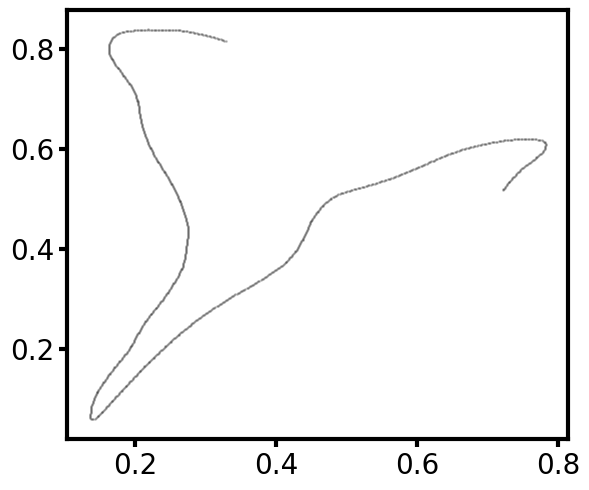

In [325]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.scatter(f[5000:6000,0], f[5000:6000,1], color='k', alpha=0.2, label='Trajectory', s = 1)


In [326]:
print(optimal, samples)

108367.7123048655 104699.37080305336


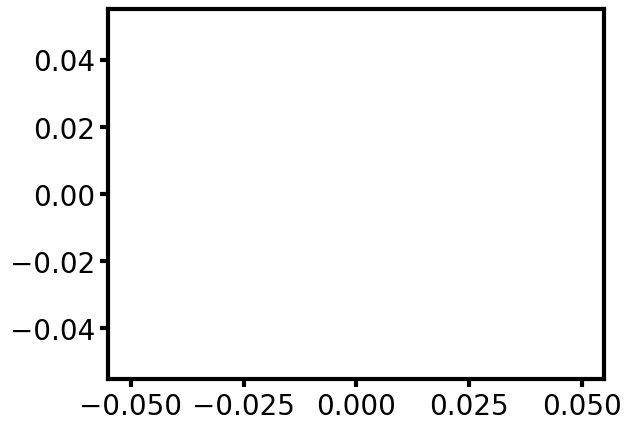

In [327]:
plt.plot(Wasserstein)
plt.show()

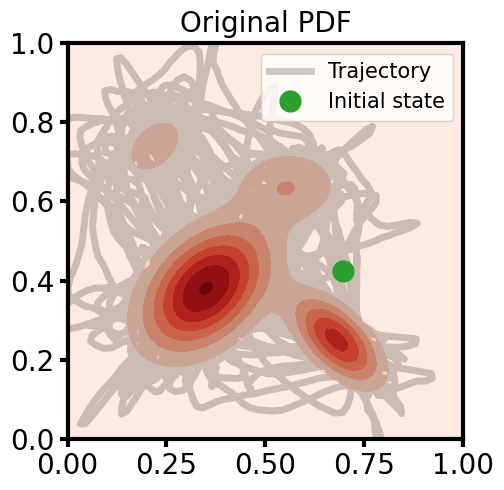

In [328]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(f[::10,0], f[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(f[0,0], f[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

In [329]:
"""from scipy.stats import gaussian_kde
x, y = f[:, 0], f[:, 1]
#samples_2d = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.6], [0.6, 1]], size=1000)
#x, y = samples_2d[:, 0], samples_2d[:, 1]
# KDE estimation
kde = gaussian_kde(np.array([x,y]), bw_method = 'silverman')
# Grid for evaluation
xgrid = np.linspace(x.min()-1, x.max()+1, 400)
ygrid = np.linspace(y.min()-1, y.max()+1, 400)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)
# Plot
plt.contourf(X, Y, Z, levels=50, cmap="viridis")
plt.colorbar(label="Density")
plt.scatter(x, y, s=5, alpha=0.3, color='white')
plt.title("2D Kernel Density Estimate")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()"""

'from scipy.stats import gaussian_kde\nx, y = f[:, 0], f[:, 1]\n#samples_2d = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.6], [0.6, 1]], size=1000)\n#x, y = samples_2d[:, 0], samples_2d[:, 1]\n# KDE estimation\nkde = gaussian_kde(np.array([x,y]), bw_method = \'silverman\')\n# Grid for evaluation\nxgrid = np.linspace(x.min()-1, x.max()+1, 400)\nygrid = np.linspace(y.min()-1, y.max()+1, 400)\nX, Y = np.meshgrid(xgrid, ygrid)\npositions = np.vstack([X.ravel(), Y.ravel()])\nZ = kde(positions).reshape(X.shape)\n# Plot\nplt.contourf(X, Y, Z, levels=50, cmap="viridis")\nplt.colorbar(label="Density")\nplt.scatter(x, y, s=5, alpha=0.3, color=\'white\')\nplt.title("2D Kernel Density Estimate")\nplt.xlabel("X")\nplt.ylabel("Y")\nplt.show()'

In [330]:
import numpy as np

def total_variation_distance(p_samples, q_samples, bins=50, range=[[0, 1], [0, 1]]):
    """
    Computes the total variation distance between two empirical distributions.
    
    Parameters:
        p_samples: np.ndarray of shape (N, 2) — samples from distribution P
        q_samples: np.ndarray of shape (M, 2) — samples from distribution Q
        bins: int or [int, int] — number of bins along each axis
        range: list of 2D bounds — [[x_min, x_max], [y_min, y_max]]
    
    Returns:
        TV distance (float)
    """
    # Compute 2D histograms
    H_p, _ = np.histogramdd(p_samples, bins=bins, range=range, density=True)
    H_q, _ = np.histogramdd(q_samples, bins=bins, range=range, density=True)

    # Bin volume
    vol = np.prod([(r[1] - r[0]) / b for r, b in zip(range, np.atleast_1d(bins))])

    # TV distance
    tv = 0.5 * np.mean(np.abs(H_p - H_q)) * vol
    return tv

mu_samples = sample_from_density_2d(pdf_vals.reshape(num_grid, num_grid), grids_x, grids_y, n_samples = f.shape[1])
tv = total_variation_distance(mu_samples, f)
print(tv)

0.01983333333333334


In [331]:
import numpy as np
from scipy.stats import wasserstein_distance

def trajectory_to_distance(f, target_samples, n_samples=1000, metric="wasserstein"):
    """
    Computes the distance between the pushforward of the uniform measure by f
    and a target distribution represented by samples.

    Parameters:
        f: function f(t), t in [0,1] -> R^d
        target_samples: array of shape (N, d), samples from target distribution
        n_samples: number of samples to draw from uniform [0,1]
        metric: "wasserstein" or "sinkhorn"

    Returns:
        scalar distance value
    """
    pushed_samples = f
    
    if metric == "wasserstein":
        # Average 1D Wasserstein over dimensions
        d = target_samples.shape[1]
        distances = [
            wasserstein_distance(pushed_samples[:, i], target_samples[:, i])
            for i in range(d)
        ]
        return np.mean(distances)
    
    elif metric == "sinkhorn":
        import ot
        a = np.ones(n_samples) / n_samples
        b = np.ones(target_samples.shape[0]) / target_samples.shape[0]
        M = ot.dist(pushed_samples, target_samples, metric='sqeuclidean')
        return ot.sinkhorn2(a, b, M, reg=0.01)[0]

    else:
        raise ValueError("Unknown metric. Use 'wasserstein' or 'sinkhorn'.")
    
trajectory_to_distance(f, mu_samples, metric = 'wasserstein')

0.12182119084872298